In [1]:
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 8
%config InlineBackend.figure_format = 'retina'
import os
import sys

if __name__ == '__main__':
    os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'tele.local')
    try:
        from django.core.management import execute_from_command_line
    except ImportError as exc:
        raise ImportError(
            "Couldn't import Django. Are you sure it's installed and "
            "available on your PYTHONPATH environment variable? Did you "
            "forget to activate a virtual environment?"
        ) from exc
    execute_from_command_line(sys.argv)

from warehouse.models import *

Unknown command: '-f'
Type 'ipykernel_launcher.py help' for usage.


SystemExit: 1

/Users/nati/workspace/tele/tele/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3333: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


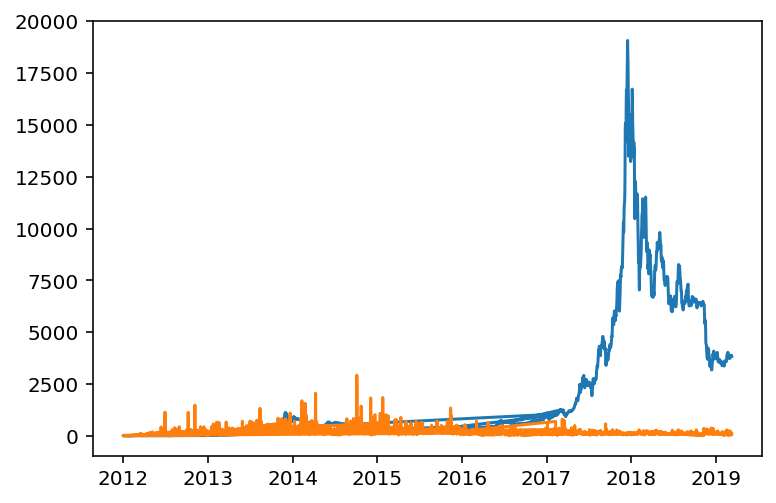

In [2]:
from django.db.models import Sum, Max, Min, Count
from django.db import connections
import psycopg2
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

with connections['warehouse_db'].cursor() as cursor:
    cursor.execute("select day_start_time,((max_low_value+min_low_value)/2+(max_high_value+min_high_value)/2)/2, (max_volumne_in_btc+min_volumne_in_btc)/2 from warehouse_reportbyday");
    result = cursor.fetchall()
    date_arr = []
    avg_value = []
    avg_volumne = []
    for data in result:
        date_arr.append(datetime.fromtimestamp(data[0]))
        avg_value.append(data[1])
        avg_volumne.append(data[2])
    fig, ax = plt.subplots(1, 1)
    ax.plot(date_arr, avg_value)
    ax.plot(date_arr, avg_volumne)
    plt.show()
    # print(result)
    

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime
from datetime import date
import random

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import gc


# import warnings

In [9]:
from django.db import connections
def load_data():
    conn = connections['warehouse_db']
    SQL_Query = pd.read_sql_query(
'''select
*, (max_weighted_price+min_weighted_price)/2 as weighted_price
from warehouse_reportbyday''', conn)
    
    df = pd.DataFrame(SQL_Query, columns=['weighted_price','day_start_time','day_minimum_time','day_maximum_time','sum_opening_value','max_opening_value','min_opening_value','sum_closing_value','max_closing_value','min_closing_value','max_high_value','min_high_value','max_low_value','min_low_value','sum_volumne_in_btc','max_volumne_in_btc','min_volumne_in_btc','sum_volumne_in_currency','max_volumne_in_currency','min_volumne_in_currency','sum_weighted_price','max_weighted_price','min_weighted_price','row_count'])
    df['Seconds'] = df.day_start_time.values.astype(int) # rename field
    df.day_start_time = pd.to_datetime(df.day_start_time, unit='s') # true timestamp
    df = df[df.sum_opening_value.notnull()] # remove fields w/o data to lower memory requirements

    df = df.reset_index().drop('index', axis=1).reset_index()
    df['counter'] = df.index
    df = df.drop('index', axis=1)
    df = df.set_index('Seconds')
    df_original = df.copy()
    
    # downsample to days
    df = df.reset_index().set_index('day_start_time').resample('D').mean()
    df = pd.DataFrame(df)
    return (df,df_original)


In [10]:
df4,_ = load_data()
print('entries missing in df2', sum(df4.weighted_price.isnull()))
# df4.day_start_time
# df4.Seconds = pd.to_datetime(df4.Seconds, unit='s')
# df4.pd.to_datetime(Train['date'])
_ = df4.reset_index().day_start_time.map(lambda y: y.date())
_ = np.asarray(_, dtype=date)
df4['Date'] = _

missing_entries_timestamp = df4[df4.weighted_price.isnull()].index
missing_entries_timestamp

entries missing in df2 3


DatetimeIndex(['2015-01-06', '2015-01-07', '2015-01-08'], dtype='datetime64[ns]', name='day_start_time', freq='D')

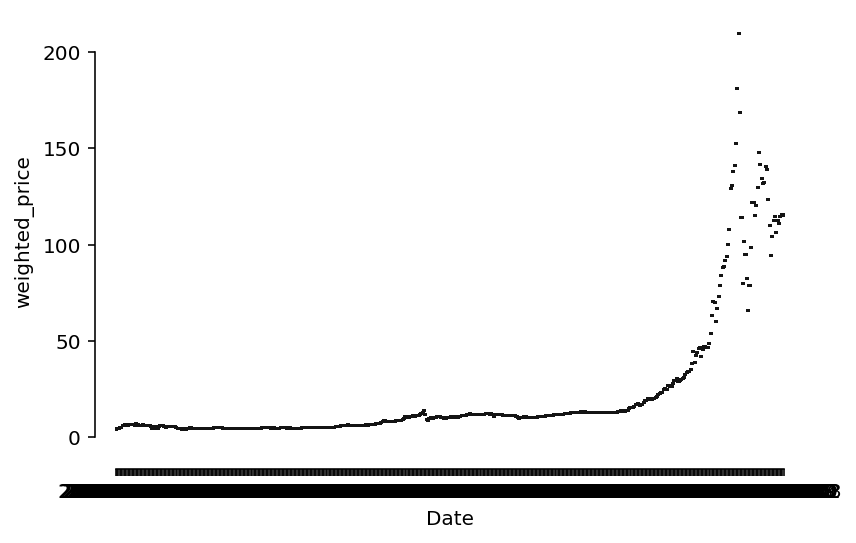

In [6]:
sns.boxplot(x="Date", y="weighted_price", data=df4[:500], palette="PRGn")
sns.despine(offset=10, trim=True)
plt.show()

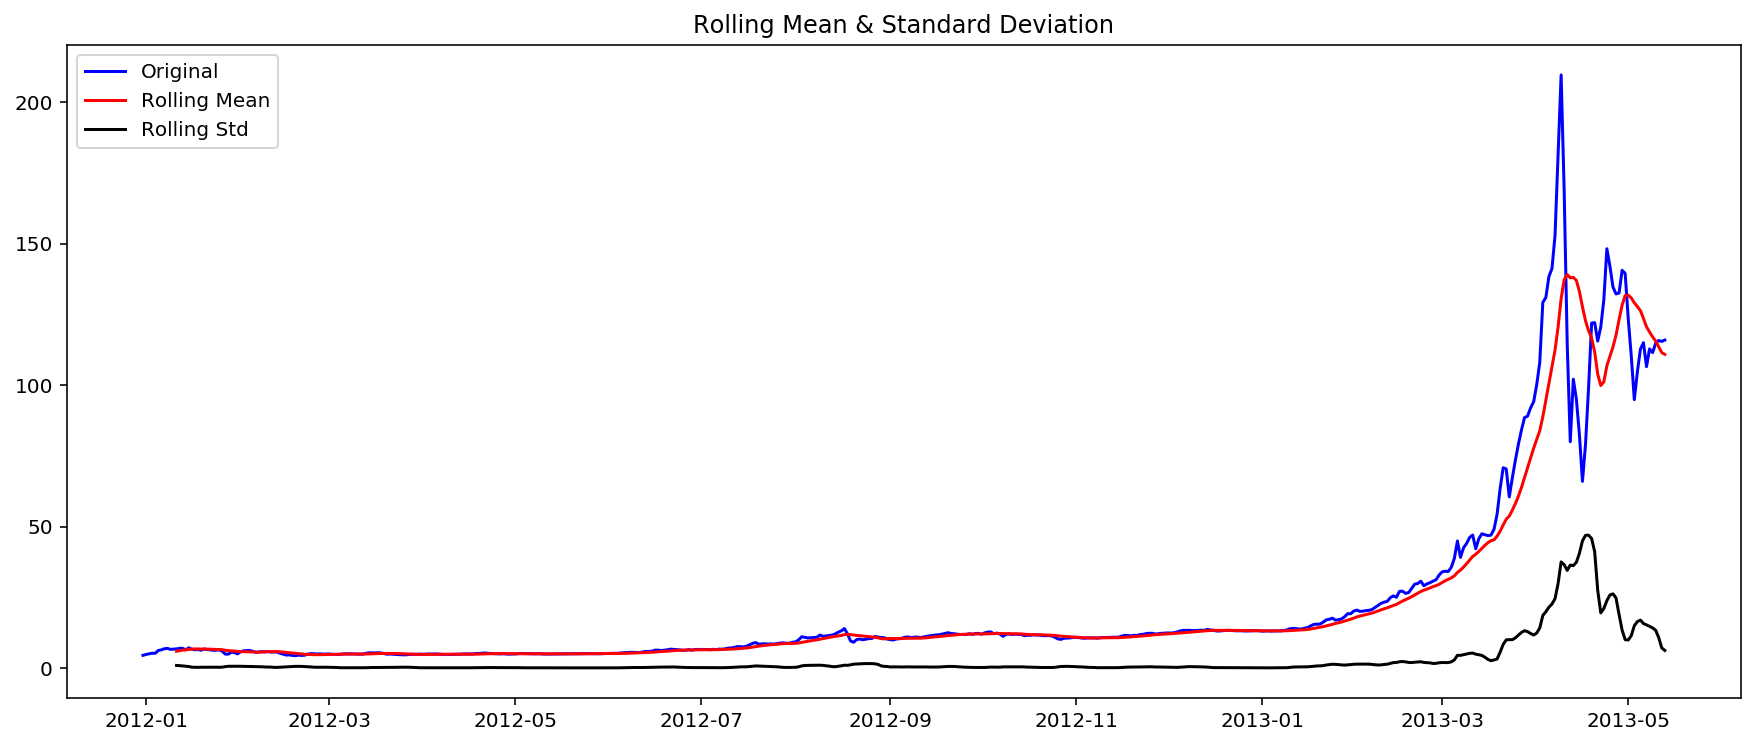

Results of Dickey-Fuller Test:
Test Statistic                   0.601154
p-value                          0.987644
#Lags Used                       9.000000
Number of Observations Used    490.000000
Critical Value (1%)             -3.443766
Critical Value (5%)             -2.867457
Critical Value (10%)            -2.569921
dtype: float64


In [11]:
df = df4.weighted_price
df = pd.DataFrame(df)
df = df[:500]
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,6))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    Dickey_Fuller_test(timeseries)
    
def Dickey_Fuller_test(timeseries):
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
df = df[df.weighted_price.notnull()]
test_stationarity(df.weighted_price)
# ts_df_log = np.log(df)


In [12]:
ts_df_log = np.log(df)
Dickey_Fuller_test(ts_df_log.weighted_price)

Results of Dickey-Fuller Test:
Test Statistic                   2.016534
p-value                          0.998694
#Lags Used                       9.000000
Number of Observations Used    490.000000
Critical Value (1%)             -3.443766
Critical Value (5%)             -2.867457
Critical Value (10%)            -2.569921
dtype: float64


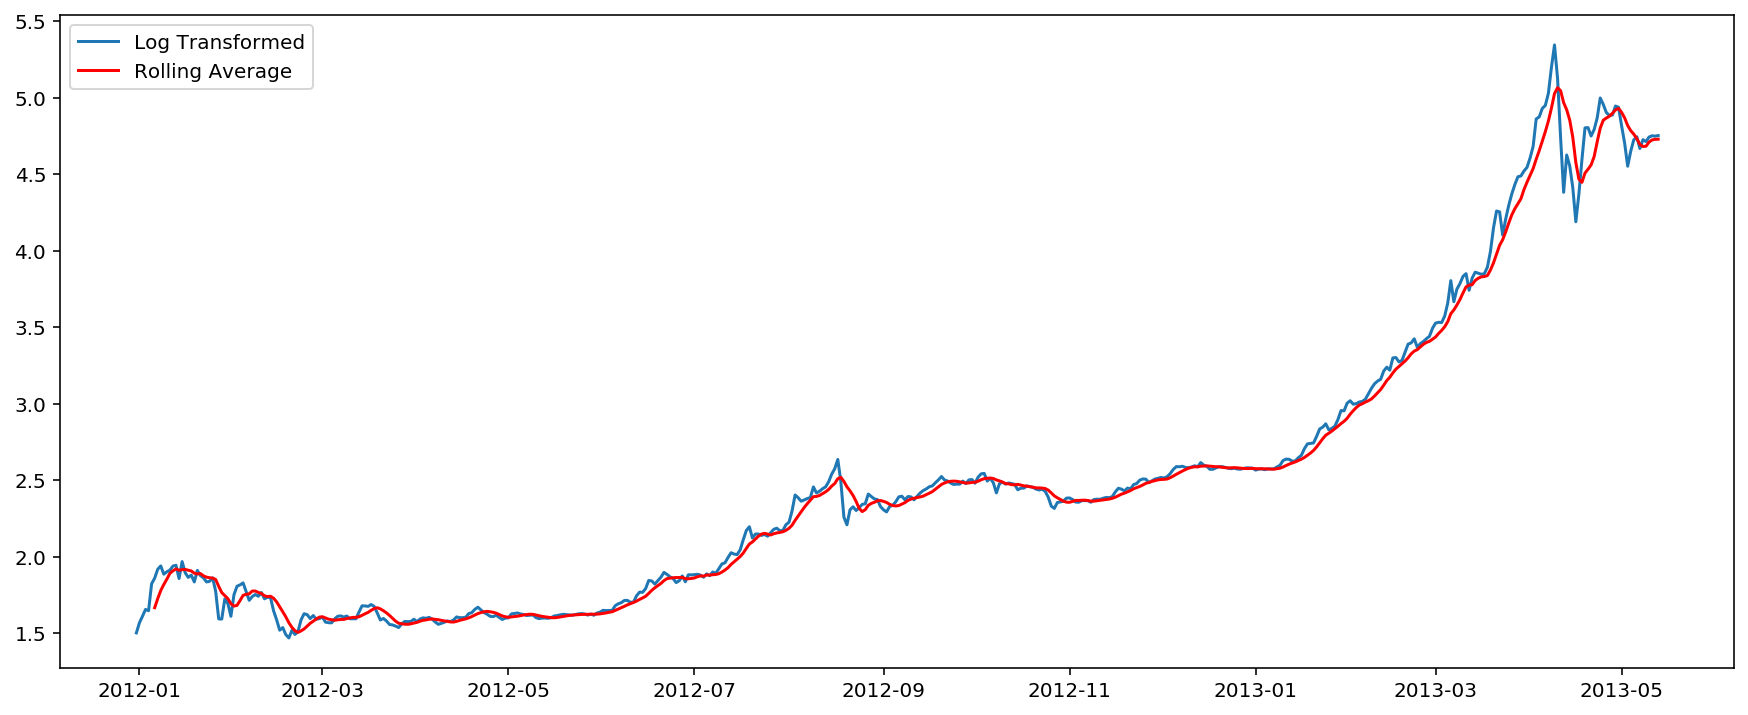

In [13]:
Rolling_average = ts_df_log.rolling(window = 7, center= False).mean()
ts_df_log_rolling = Rolling_average.dropna()
plt.figure(figsize=(15,6))
plt.plot(ts_df_log, label = 'Log Transformed')
plt.plot(ts_df_log_rolling, color = 'red', label = 'Rolling Average')
plt.legend(loc = 'best')
plt.show()

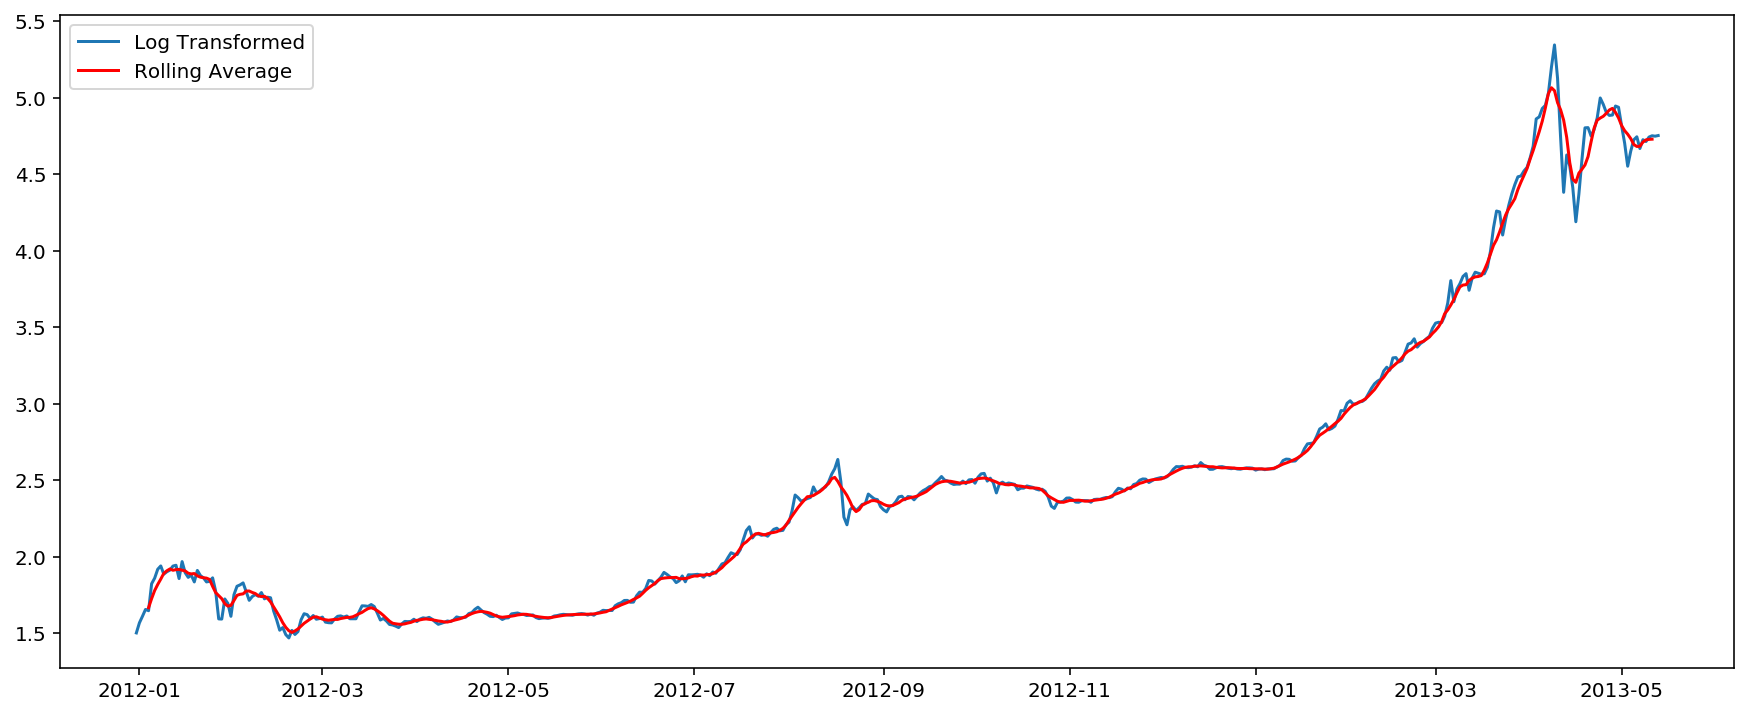

In [14]:
window = 7
shift_by_days = -2
Rolling_average = ts_df_log.rolling(window = window, center= False).mean()
ts_df_log_rolling_temp = Rolling_average.shift(shift_by_days).dropna()
plt.figure(figsize=(15,6))
plt.plot(ts_df_log, label = 'Log Transformed')
plt.plot(ts_df_log_rolling_temp, color = 'red', label = 'Rolling Average')
plt.legend(loc = 'best')
plt.show()

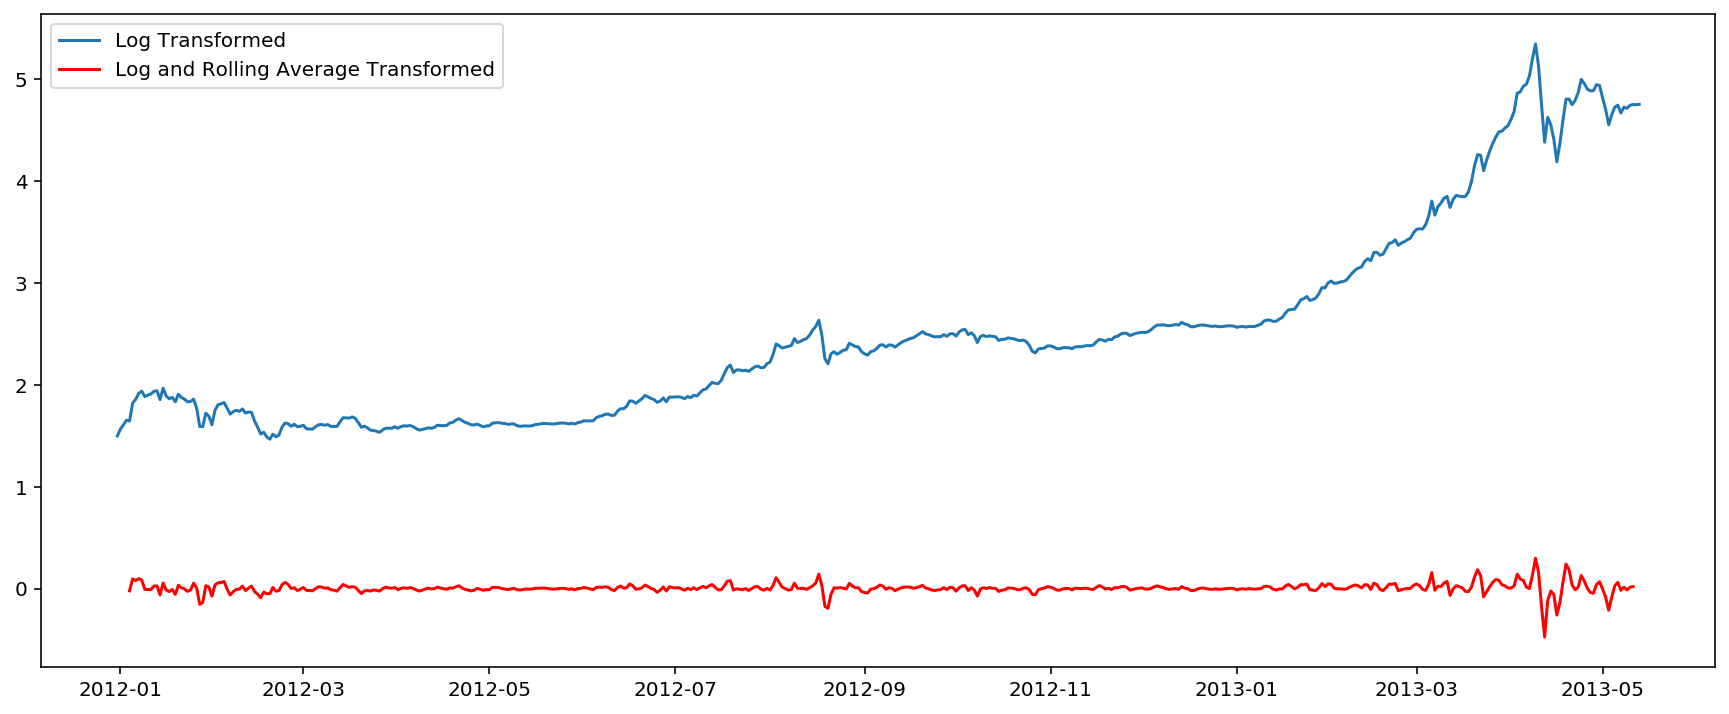

Results of Dickey-Fuller Test:
Test Statistic                -9.751042e+00
p-value                        8.014566e-17
#Lags Used                     6.000000e+00
Number of Observations Used    4.870000e+02
Critical Value (1%)           -3.443849e+00
Critical Value (5%)           -2.867493e+00
Critical Value (10%)          -2.569941e+00
dtype: float64


In [15]:
ts_df_log_rolling = (ts_df_log - ts_df_log_rolling_temp).dropna()
plt.figure(figsize=(15,6))
plt.plot(ts_df_log, label = 'Log Transformed')
plt.plot(ts_df_log_rolling, color = 'red', label = 'Log and Rolling Average Transformed')
plt.legend(loc = 'best')
plt.show()
Dickey_Fuller_test(ts_df_log_rolling.weighted_price)

In [16]:
lag = 20
lag_pacf = pacf(ts_df_log_rolling, nlags=lag, method='ols')
lag_acf = acf(ts_df_log_rolling, nlags=lag)

/Users/nati/workspace/tele/tele/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


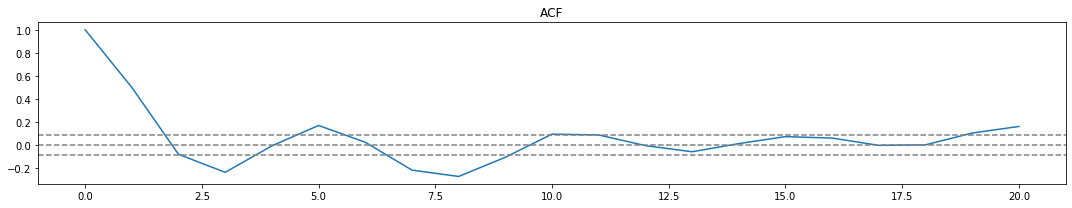

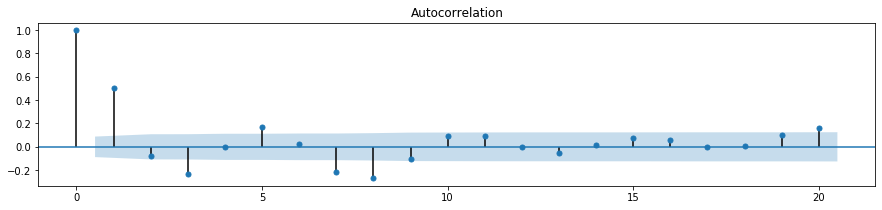

In [104]:
#Plot ACF: 
plt.figure(figsize=(15,3))
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_df_log_rolling)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_df_log_rolling)),linestyle='--',color='gray')
plt.title('ACF')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,3))
plot_acf(ts_df_log_rolling, ax=plt.gca(),lags=lag)
plt.show()

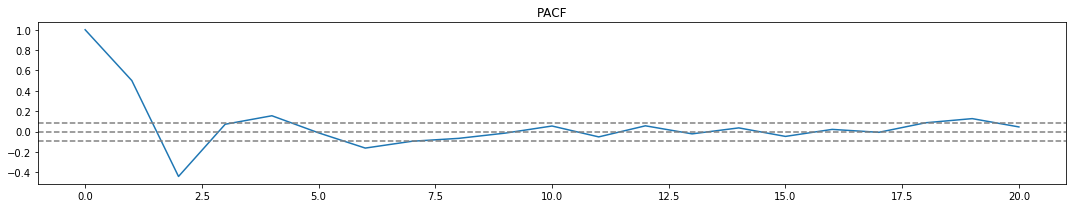

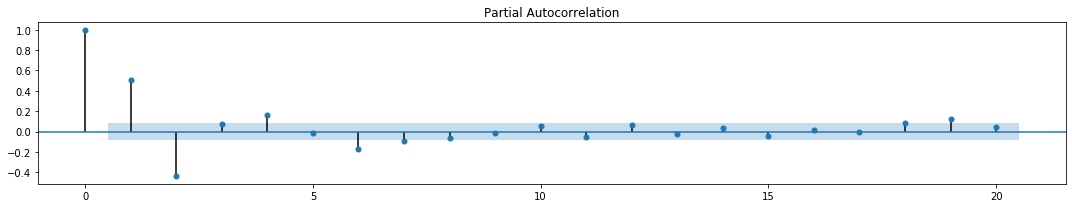

In [105]:
#Plot PACF:
plt.figure(figsize=(15,3))
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_df_log_rolling)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_df_log_rolling)),linestyle='--',color='gray')
plt.title('PACF')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,3))
plot_pacf(ts_df_log_rolling, ax=plt.gca(), lags=lag)
plt.tight_layout()
plt.show()

/Users/nati/workspace/tele/tele/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/nati/workspace/tele/tele/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


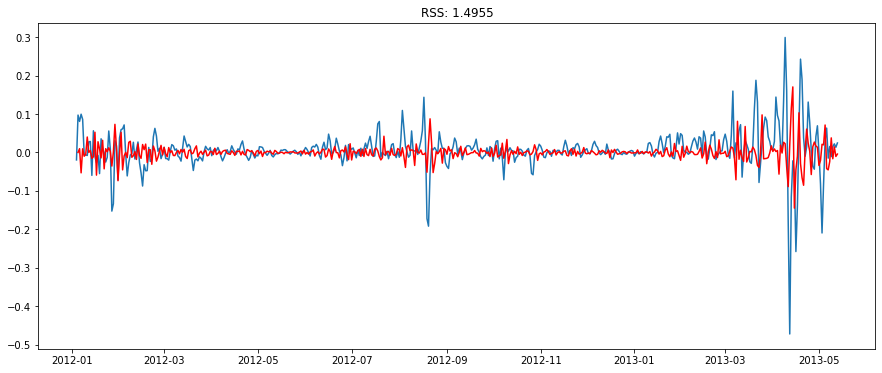

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:       D.weighted_price   No. Observations:                  495
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 835.635
Method:                       css-mle   S.D. of innovations              0.045
Date:                Sun, 28 Jul 2019   AIC                          -1663.271
Time:                        04:38:12   BIC                          -1646.452
Sample:                    01-05-2012   HQIC                         -1656.668
                         - 05-13-2013                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   4.392e-05      0.002      0.029      0.977      -0.003       0.003
ar.L1.D.weighted_price     0.1205      0.041      2.964      0.003       0.041       0.200
ar.L2.D.weighted_price    -0.4378      0.041    -10.799      0.000      -0.517      -0.358
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.1376           -1.5050j            1.5113           -0.2355
AR.2            0.1376           +1.5050j            1.5113            0.2355
-----------------------------------------------------------------------------
"""

In [107]:
p=2
q=2
d=1
model = ARIMA(ts_df_log_rolling, order=(p, d, 0))  
results_AR = model.fit(disp=-1)
plt.figure(figsize=(15,6))
plt.plot(ts_df_log_rolling)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_df_log_rolling.weighted_price).dropna()**2))
plt.show()
results_AR.summary()

/Users/nati/workspace/tele/tele/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/nati/workspace/tele/tele/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


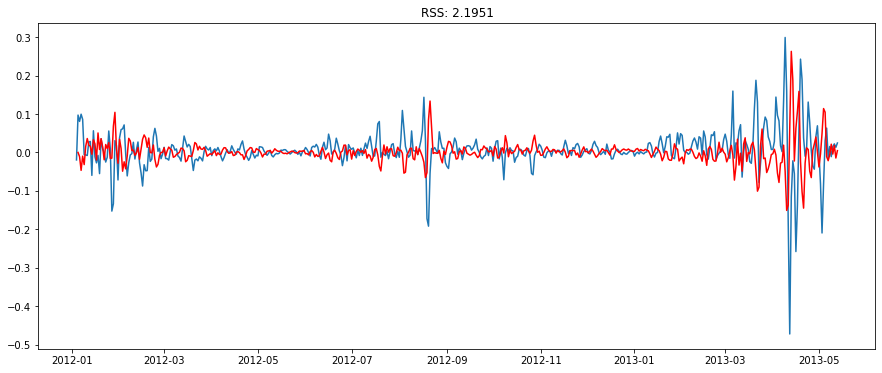

In [108]:
model = ARIMA(ts_df_log_rolling, order=(0, d, q))  
results_MA = model.fit(disp=-1) 
plt.figure(figsize=(15,6))
plt.plot(ts_df_log_rolling)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_df_log_rolling.weighted_price).dropna()**2))
plt.show()

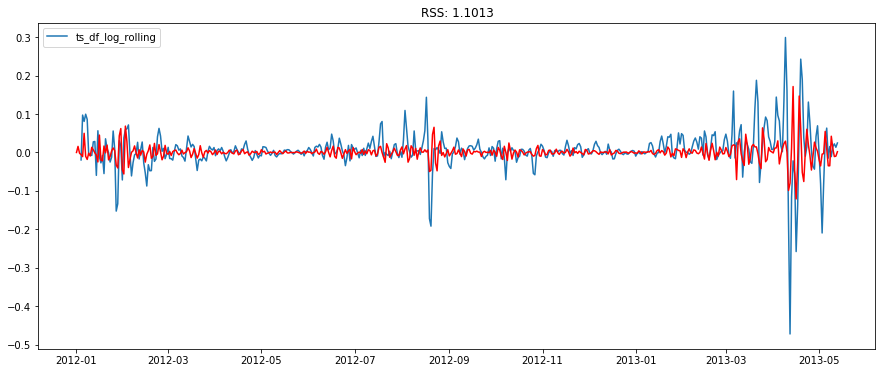

In [109]:
# ARIMA
model = ARIMA(ts_df_log, order=(p, d, q))  
results_ARIMA = model.fit(disp=-1, trend='nc')
plt.figure(figsize=(15,6))
plt.plot(ts_df_log_rolling, label='ts_df_log_rolling')
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_df_log_rolling.weighted_price).dropna()**2))
plt.legend(loc='best')
plt.show()

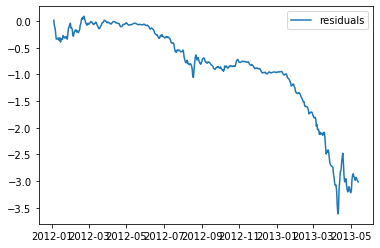

day_start_time
2012-01-01    0.000000
2012-01-02    0.015776
2012-01-03   -0.002082
2012-01-04   -0.005547
2012-01-05   -0.010816
                ...   
2013-05-09    0.042244
2013-05-10    0.010356
2013-05-11   -0.010617
2013-05-12   -0.009690
2013-05-13    0.002000
Freq: D, Length: 499, dtype: float64


In [110]:
x = pd.DataFrame(results_ARIMA.fittedvalues)
x.columns = ts_df_log_rolling.columns
x = x - ts_df_log_rolling
x = x.cumsum()
plt.plot(x, label='residuals')
plt.legend(loc='best')
plt.show()
print(results_ARIMA.fittedvalues)

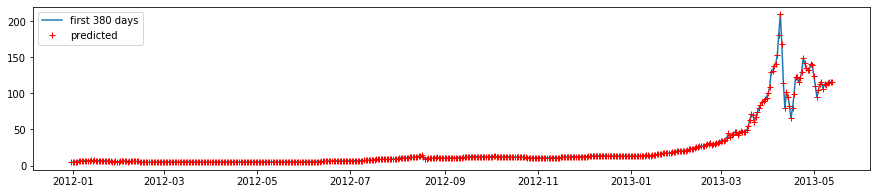

In [115]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_df_log.weighted_price, index=ts_df_log.index)
predictions_ARIMA = np.exp(predictions_ARIMA_log)

plt.figure(figsize=(15,3))
plt.plot(df, label='first 380 days')
plt.plot(predictions_ARIMA, 'r+', label='predicted')
plt.legend(loc='best')
plt.show()


2628
2013-05-14    6.919655e-03
2013-05-15    1.004508e-03
2013-05-16   -4.409314e-03
2013-05-17   -2.470242e-03
2013-05-18    2.074369e-03
                  ...     
2013-11-26   -2.161707e-18
2013-11-27   -1.363377e-18
2013-11-28    9.557807e-19
2013-11-29    1.332296e-18
2013-11-30   -1.294971e-19
Freq: D, Length: 201, dtype: float64


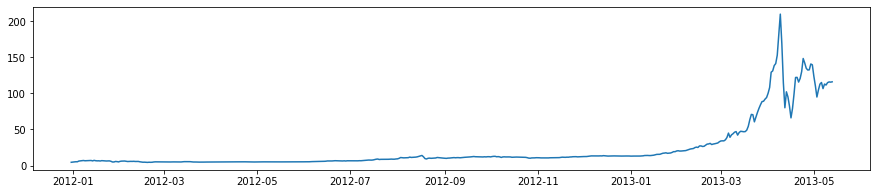

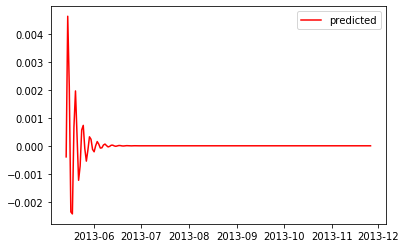

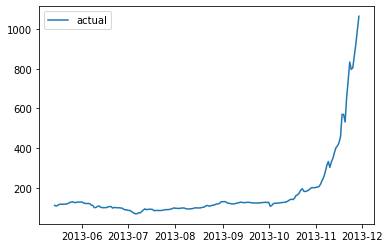

In [116]:
from warehouse.models import *
count = ReportByDay.objects.count()
print(count)
start = 500
end = 700
forecast = results_ARIMA.predict(start=start, end=end)
print(forecast)
f = (forecast + forecast.shift(-1))
f = f.shift(-3).dropna()
forecast = f

plt.figure(figsize=(15,3))
plt.plot(df[:end].weighted_price, label='original data')
plt.show()
plt.plot(forecast, color='red', label='predicted')
plt.legend(loc='best')
plt.show()
plt.plot(df4[start:end].weighted_price, label='actual')
plt.legend(loc='best')
plt.show()